# Portfolio Optimization with the Quantum Approximate Optimization Algorithm (QAOA)

Portfolio optimization [[1](#PortfolioWiki)] is the process of optimally allocating a portfolio of financial assets, according to some predetermined goal. Usually, the goal is to maximize the potential return while minimizing the financial risk of the portfolio. One can express this problem as a combinatorial optimization problem like many other real-world problems. This demo shows how to employ the Quantum Approximate Optimization Algorithm (QAOA) [[2](#QAOA)] on the Classiq platform to solve the problem of portfolio optimization.

## Modeling the Portfolio Optimization Problem

First, model the problem mathematically using a simple yet powerful model that captures the essence of portfolio optimization:

- A portfolio is built from a pool of $n$ financial assets, with each asset labeled $i \in \{1,\ldots,n\}$.
- Every asset's return is a random variable, with expected value $\mu_i$ and variance $\Sigma_i$ (modeling the financial risk involved in the asset).
- Every two assets $i \neq j$ have covariance $\Sigma_{ij}$ (modeling market correlation between assets).
- Every asset $i$ has a weight $w_i \in D_i = \{0,\ldots,b_i\}$ in the portfolio, with $b_i$ defined as the budget for asset $i$ (modeling the maximum allowed weight of the asset).
- The return vector $\mu$, the covariance matrix $\Sigma$, and the weight vector $w$ are defined naturally from the above (with the domain $D = D_1 \times D_2 \times \ldots \times D_n$ for $w$).

With the above definitions, the total expected return of the portfolio is $\mu^T w$ and the total risk is $w^T \Sigma w$. Use a simple difference of the two as the cost function, with the additional constraint that the total sum of assets does not exceed a predefined budget $B$. Note that there are many other possibilities for defining a cost function (such as adding a scaling factor to the risk/return or even a non-linear relation). For simplicity, select the model below and assume all constants and variables are dimensionless.
Thus, given the constant inputs $\mu, \Sigma, D, B$, the problem is to find the optimal variable $w$:

$\begin{equation*}
\min_{w \in D}  w^T \Sigma w - \mu^T w,
\end{equation*}$
subject to $\Sigma_{i} w_i \leq B$.

This case is called integer portfolio optimization, since the domains $D_i$ are over the (positive) integers.
Another variation of this problem defines weights over binary domains, and is not discussed here.


### Setup

With the mathematical definition in place, begin the implementation by importing necessary packages and classes. Use these external dependencies:

- NumPy
- Matplotlib
- Pyomo - a Python framework for modeling optimization problems, which the Classiq platform uses as an interface to these types of problems

From the `classiq` package, import classes related to combinatorial optimization and QAOA:


In [1]:
import numpy as np
import pyomo.core as pyo

### Portfolio Optimization Problem Parameters

Define the parameters of the optimization problem, which include the expected return vector, the covariance matrix, and the total budget:

In [2]:
returns = np.array([3, 4, -1])
covariances = np.array(
    [
        [0.9, 0.5, -0.7],
        [0.5, 0.9, -0.2],
        [-0.7, -0.2, 0.9],
    ]
)

total_budget = 6

## Pyomo Model for the Problem

Define the Pyomo model to use on the Classiq platform, using the problem parameters defined above:

In [3]:
portfolio_model = pyo.ConcreteModel("portfolio_optimization")
num_assets = len(returns)

# setting the variables
portfolio_model.w = pyo.Var(range(num_assets), domain=pyo.Integers, bounds=(0, 7))

w_array = list(portfolio_model.w.values())

# global budget constraint
portfolio_model.budget_rule = pyo.Constraint(expr=(sum(w_array) <= total_budget))

# setting the expected return and risk
portfolio_model.expected_return = returns @ w_array
portfolio_model.risk = w_array @ covariances @ w_array

# setting the cost function to minimize
portfolio_model.cost = pyo.Objective(
    expr=portfolio_model.risk - portfolio_model.expected_return, sense=pyo.minimize
)

### Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the `CombinatorialProblem` Python class. Under the hood, it translates the Pyomo model to a quantum model of the QAOA algorithm, with the cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument and the `penalty_factor`, which is the coefficient of the constraints term in the cost Hamiltonian:

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=portfolio_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "portfolio_optimization")

### Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/83bbd639-d2b0-4fb6-b89b-b9a790a5bd4d?version=0.63.0.dev2


Set the quantum backend for execution:

In [7]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

Solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimized_params = combi.optimize(execution_preferences, maxiter=60, quantile=0.7)

Optimization Progress: 61it [05:10,  5.09s/it]                                                                                                                                                                                                     


Check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

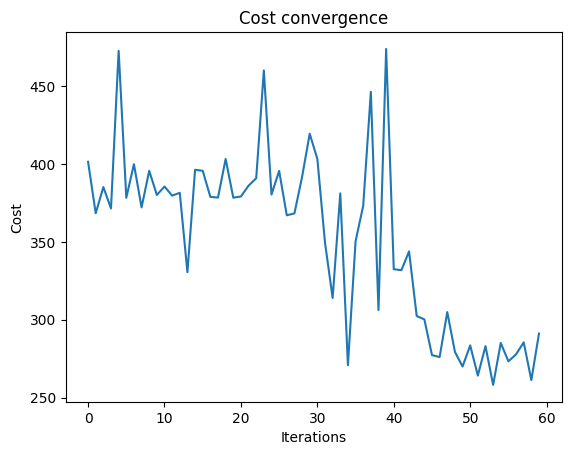

In [9]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

Examine the statistics of the algorithm. The optimization is always defined as a minimization problem, so the positive maximization objective is translated to negative minimization by the Pyomo-to-Qmod translator.

To get samples with the optimized parameters, call the `sample` method:

In [10]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
180,"{'w': [1, 2, 1], 'budget_rule_slack_var': [0, ...",0.000977,-4.8
515,"{'w': [3, 1, 2], 'budget_rule_slack_var': [0, ...",0.000488,-4.6
112,"{'w': [2, 2, 2], 'budget_rule_slack_var': [0, ...",0.001465,-4.4
713,"{'w': [2, 1, 2], 'budget_rule_slack_var': [1, ...",0.000488,-4.3
1285,"{'w': [1, 1, 0], 'budget_rule_slack_var': [1, ...",0.000488,-4.2


Compare the optimized results to uniformly sampled results:

In [11]:
uniform_result = combi.sample_uniform()

And compare the histograms:

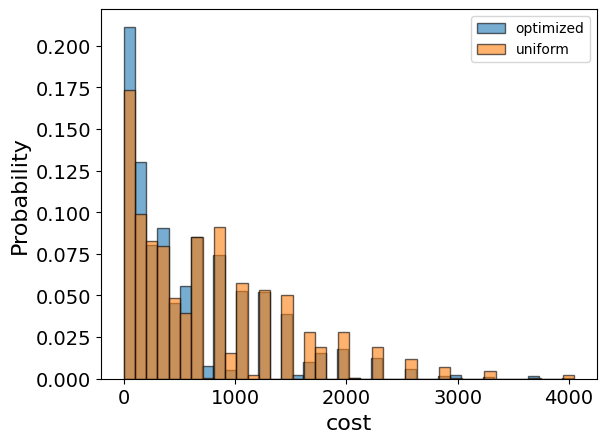

In [12]:
optimization_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

In [13]:
best_solution = optimization_result.loc[optimization_result.cost.idxmin()]
print(
    "x =",
    best_solution.solution["w"],
    ", cost =",
    best_solution.cost,
)

x = [1, 2, 1] , cost = -4.8


Lastly, compare with the classical solution of the problem:

In [14]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(portfolio_model)

portfolio_model.display()
classical_solution = [
    round(pyo.value(portfolio_model.w[i])) for i in range(len(portfolio_model.w))
]
print("Classical solution:", classical_solution)

Model portfolio_optimization

  Variables:
    w : Size=3, Index=w_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   2.0 :     7 : False : False : Integers
          1 :     0 :   1.0 :     7 : False : False : Integers
          2 :     0 :   1.0 :     7 : False : False : Integers

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : -4.800000000000001

  Constraints:
    budget_rule : Size=1
        Key  : Lower : Body : Upper
        None :  None :  4.0 :   6.0
Classical solution: [2, 1, 1]


Most of the solutions obtained by running QAOA are close to the minimal solution obtained classically, demonstrating the effectiveness of the algorithm. Also, note the non-trivial solution, which includes a non-zero weight for the asset with negative expected return, demonstrating that it sometimes makes sense to include such assets in the portfolio as a risk-mitigation strategy - especially if they are highly anti-correlated with the rest of the assets.


## References

<a id='PortfolioWiki'>[1]</a> [Portfolio Optimization (Wikipedia)](https://en.wikipedia.org/wiki/Portfolio_optimization)

<a id='QAOA'>[2]</a> [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a> [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
